In [2]:
from typing import Callable
import unittest
import copy

# Sci Math Packages
import math
import numpy as np

# np.random.seed(0)  # Fixing the seed for predictable randomness
np.set_printoptions(formatter={"float": lambda x: "{0:0.2f}".format(x)})
import pandas as pd
from scipy import spatial
from scipy.special import entr
from scipy.stats import truncnorm
from sklearn.manifold import TSNE
from sklearn import metrics

# Plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

try:
    import google.colab

    # If import is successful, then we are running in colab
    !mkdir results
    !mkdir simulation_results
    # Load all files from Google Drive to this notebook
    # Import PyDrive and associated libraries.
    # This only needs to be done once per notebook.
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    # Authenticate and create the PyDrive client.
    # This only needs to be done once per notebook.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

    # Load all files from my Google Drive to this Jupyter environment
    # https://drive.google.com/open?id=1uQhwdg2QHqRmk3ARIRCvHJDEXOxn822W
    drive.CreateFile({"id": "1uQhwdg2QHqRmk3ARIRCvHJDEXOxn822W"}).GetContentFile(
        "./results/author_features.csv"
    )
    # https://drive.google.com/open?id=1rYuELMib1XNS7ouXwyAWbf3KvrdcsCfq
    drive.CreateFile({"id": "1rYuELMib1XNS7ouXwyAWbf3KvrdcsCfq"}).GetContentFile(
        "./results/hindex.csv"
    )
    # https://drive.google.com/open?id=1W1DwCoIYhZUMCpUTEz_bM9WE4NOOZ-Fj
    drive.CreateFile({"id": "1W1DwCoIYhZUMCpUTEz_bM9WE4NOOZ-Fj"}).GetContentFile(
        "./results/kdd_paper_author_affiliations_for_authors.csv"
    )
    # https://drive.google.com/open?id=12_zWhouELtkBdrnzgAwGy2l1QeFcp7L9
    drive.CreateFile({"id": "12_zWhouELtkBdrnzgAwGy2l1QeFcp7L9"}).GetContentFile(
        "./results/kdd_papers.csv"
    )
    # https://drive.google.com/open?id=1CwIkHGD016oN9E3eMx_yHIdseBJyCPEE
    drive.CreateFile({"id": "1CwIkHGD016oN9E3eMx_yHIdseBJyCPEE"}).GetContentFile(
        "./results/paper_features.csv"
    )
    # Checking that all files are loaded
    !ls results/
except:
    # If not running on colab, import lab_black
    %load_ext lab_black


# Loading all CSV files into memory only once to save time
# Constants
AUTHOR_FEATURE_CSV = pd.read_csv("../results/author_features.csv", index_col=0)
HINDEX_CSV = pd.read_csv("../results/hindex.csv", index_col=0)
KDD_PAPER_AUTHOR_CSV = pd.read_csv(
    "../results/kdd_paper_author_affiliations_for_authors.csv", index_col=0
)
KDD_PAPER_CSV = pd.read_csv("../results/kdd_papers.csv", index_col=0)
PAPER_FEATURE_CSV = pd.read_csv("../results/paper_features.csv", index_col=0)

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [3]:
class Reviewers:
    def __init__(self):
        _features = AUTHOR_FEATURE_CSV.copy(deep=True)
        _h_index = HINDEX_CSV.copy(deep=True)

        # Remove 0 value features
        _features = _features.loc[~(_features == 0).all(axis=1)]
        _indexes = _features.index.values.tolist()
        self.features = _features.to_numpy()
        self.h_index = np.array(
            [int(_h_index[_h_index["0"] == _index]["2"]) for _index in _indexes]
        )
        print(
            f"Reviewer features of size: {self.features.shape}, h index of size {self.h_index.shape}"
        )

    def sample(self, number):
        if number > self.features.shape[0]:
            raise Exception("number too large")
        else:
            _index = np.random.choice(self.features.shape[0], number, replace=False)
            return self.features[_index], self.h_index[_index]

    def plot(self):
        _fig, _ax = plt.subplots(figsize=(6, 4))
        sns.distplot(self.h_index, ax=_ax, kde=False, hist=True, bins=50)
        plt.xlabel("Scholar Research Impact Score (h-index)")
        plt.ylabel("Number of Scholars")
        plt.rc("grid", linestyle="--", color="gray")
        plt.grid(which="major")
        plt.show()

In [4]:
class Papers:
    def __init__(self, from_year: int = 2014, to_year: int = 2018):
        _kdd_papers = KDD_PAPER_CSV.copy(deep=True)
        # Filter papers based on year
        _kdd_papers = _kdd_papers[
            np.logical_and(from_year <= _kdd_papers.Year, _kdd_papers.Year <= to_year)
        ]
        # Filter features based on paper ids
        _features = PAPER_FEATURE_CSV.copy(deep=True)
        _features = _features[_features.index.isin(_kdd_papers.PaperId)]
        # Remove 0 value features
        _features = _features.loc[~(_features == 0).all(axis=1)]
        _author_paper = KDD_PAPER_AUTHOR_CSV.copy(deep=True)
        _h_index = HINDEX_CSV.copy(deep=True)

        _indexes = _features.index.values.tolist()

        self.h_index = []
        self.citation = []
        self.year = []
        for _index in _indexes:
            _author_indexes = list(
                _author_paper[_author_paper["PaperId"] == _index]["AuthorId"]
            )
            self.h_index.append(
                [int(_h_index[_h_index["0"] == _x]["2"]) for _x in _author_indexes]
            )
            _paper = _kdd_papers[_kdd_papers["PaperId"] == _index]
            self.citation.append(_paper["CitationCount"].item())
            self.year.append(_paper["Year"].item())

        self.h_index = np.array(self.h_index)
        self.citation = np.array(self.citation)
        self.year = np.array(self.year)
        self.features = _features.to_numpy()
        print(f"Paper features of size: {self.features.shape}")

    def sample(self, number):
        if number > self.features.shape[0]:
            raise Exception("number too large")
        else:
            _index = np.random.choice(self.features.shape[0], number, replace=False)
            return (
                self.features[_index],
                self.h_index[_index],
                self.citation[_index],
                self.year[_index],
            )

    def plot(self):
        average_h_index = np.array([np.average(x) for x in self.h_index])
        _fig, _ax = plt.subplots(figsize=(6, 4))
        sns.distplot(average_h_index, ax=_ax, kde=False, hist=True, bins=100)
        plt.xlabel("Average Author h-index of All KDD Papers")
        plt.ylabel("Number of Papers")
        plt.rc("grid", linestyle="--", color="gray")
        plt.grid()
        plt.show()

In [5]:
def non_zero_balance(expected_rewards, submission_fee):
    """
    this function checks the negative cashflows do not exceed the positive cashflow.
    negative cashflow includes the critical review rewards.
    positive cashflow includes the constructive review fees + the submission fees.
    a constant discount model is applied if we run out of balance (to the critical reviewers).
    @param expected_rewards: the expected reward of each reviewr, of the shape [N_Reviewer, N_Paper]
    @param submission_fee: the submission fee of each paper, of the shape [N_Paper]
    """
    expected_rewards = np.nan_to_num(expected_rewards)
    _negative_cash_flows = ((expected_rewards < 0) * expected_rewards).sum(0)
    _positive_cash_flows = ((expected_rewards > 0) * expected_rewards).sum(
        0
    ) + submission_fee
    _needs_to_scale = _positive_cash_flows < (-_negative_cash_flows)
    # calculates the scale, but have 0 for papers that do not need to scale
    _scale = np.nan_to_num(
        _needs_to_scale * (_positive_cash_flows / (-_negative_cash_flows))
    )
    # convert the papers that do not need to scale to 1
    _scale += ~(_needs_to_scale)
    _scale = (expected_rewards < 0) * _scale + (expected_rewards > 0)
    return expected_rewards * _scale


class TestNotebook(unittest.TestCase):
    def test_non_zero_balance(self):
        expected_rewards = np.array([[10, 10], [-20, 10], [-30, 10], [-30, -30]]).T
        submission_fee = np.array([10, 10, 10, 10])
        np.testing.assert_array_almost_equal(
            non_zero_balance(expected_rewards, submission_fee),
            np.array([[10, 10], [-20, 10], [-20, 10], [-5, -5]]).T,
        )

    def test_nan_values(self):
        expected_rewards = np.array(
            [[np.nan, -20], [np.nan, np.nan], [np.nan, 20], [20, np.nan]]
        ).T
        submission_fee = np.array([10, 10, 10, 10])
        np.testing.assert_array_almost_equal(
            non_zero_balance(expected_rewards, submission_fee),
            np.array([[0, -10], [0, 0], [0, 20], [20, 0]]).T,
        )


unittest.main(argv=[""], verbosity=2, exit=False)

test_nan_values (__main__.TestNotebook) ... /home/ec2-user/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/home/ec2-user/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in multiply
ok
test_non_zero_balance (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.007s

OK


In [6]:
def compute_final_balance(actual_rewards, submission_fee):
    return np.add(submission_fee, np.nansum(actual_rewards, axis=0))


class TestNotebook(unittest.TestCase):
    def test_final_balance(self):
        expected_rewards = np.array(
            [
                [10, 10],
                [-20, 10],
                [-30, 10],
                [-30, -30],
                [np.nan, -20],
                [np.nan, np.nan],
                [np.nan, 20],
                [20, np.nan],
            ]
        ).T
        submission_fee = np.array([10] * 8)
        np.testing.assert_array_almost_equal(
            compute_final_balance(
                non_zero_balance(expected_rewards, submission_fee), submission_fee
            ),
            np.array([30, 0, 0, 0, 0, 10, 30, 30]).T,
        )


unittest.main(argv=[""], verbosity=2, exit=False)

test_final_balance (__main__.TestNotebook) ... /home/ec2-user/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/home/ec2-user/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in multiply
ok

----------------------------------------------------------------------
Ran 1 test in 0.005s

OK


In [7]:
class Simulation:
    def __init__(self, p_feature, p_h_index, p_citation, p_year, r_feature, r_h_index):
        self.p_feature = p_feature
        self.p_h_index = p_h_index
        self.p_citation = p_citation
        self.p_year = p_year
        self.r_feature = r_feature
        self.r_h_index = r_h_index
        vector_entropy = lambda x: entr(x / x.sum()).sum()
        self.p_entropy = np.array([vector_entropy(x) for x in self.p_feature])

        # Attributes to be defined:
        self.attractive = None
        self.quality = None
        self.likelihood = None
        self.p_balances = None
        self.score = None
        self.review_transfer = None

    def calculate_quality(self, func: Callable[["Simulation"], np.array]):
        self.quality = func(self)

    def calculate_attractive(self, func: Callable[["Simulation"], np.array]):
        self.attractive = func(self)

    def calculate_review_likelihood(self, func: Callable[["Simulation"], np.array]):
        self.likelihood = func(self)

    def calculate_submission_fees(self, func: Callable[["Simulation"], np.array]):
        self.p_balances = func(self)

    def calculate_review_scores(self, func: Callable[["Simulation"], np.array]):
        self.score = func(self)

    def calculate_review_fees(self, func: Callable[["Simulation"], np.array]):
        self.review_transfer = func(self)
        self.review_transfer = non_zero_balance(self.review_transfer, self.p_balances)

    def calculate_final_balance(self):
        self.p_balances = compute_final_balance(self.review_transfer, self.p_balances)

In [8]:
class Visualisation(Simulation):
    def visualise_attractive_vs_citation(self):
        _fig, _ax = plt.subplots(figsize=(6, 4))

        plt.scatter(self.attractive, self.quality, alpha=0.5)

        plt.xlabel("Normalised Paper Attractive Score")
        plt.ylabel("Normalised Average Number of Citations")
        plt.grid(which="major")
        plt.show()

    def visualise_quality(self):
        _fig, _ax = plt.subplots(figsize=(6, 4))

        sns.distplot(
            np.array(self.quality),
            ax=_ax,
            kde=False,
            hist=True,
            hist_kws={"range": [0, 1]},
            bins=100,
        )
        plt.xlabel("Normalised Paper Quality Score")
        plt.ylabel("Number of Papers")
        plt.rc("grid", linestyle="--", color="gray")
        plt.grid(which="major")
        plt.show()

    def visualise_attractive(self):
        _fig, _ax = plt.subplots(figsize=(6, 4))

        sns.distplot(
            np.array(self.attractive),
            ax=_ax,
            kde=False,
            hist=True,
            hist_kws={"range": [0, 1]},
            bins=100,
        )
        plt.xlabel("Normalised Paper Attractive Score")
        plt.ylabel("Number of Papers")
        plt.rc("grid", linestyle="--", color="gray")
        plt.grid(which="major")
        plt.show()

    def visualise_score(self):
        _x = self.score.flatten()
        _x = _x[~np.isnan(_x)]
        _fig, _ax = plt.subplots(figsize=(6, 4))
        sns.distplot(
            np.array(_x),
            ax=_ax,
            kde=False,
            hist=True,
            hist_kws={"range": [0, 1]},
            bins=100,
        )
        plt.xlabel("Review Scores")
        plt.ylabel("Number of Reviews")
        plt.rc("grid", linestyle="--", color="gray")
        plt.grid(which="major")
        plt.show()

    def visualise_similarity_distributions(self):
        _x1 = self.likelihood.flatten()
        # links that given a score
        _linked = [1 if not np.isnan(x) else x for x in self.score.flatten()]
        _x2 = np.multiply(_x1, _linked)
        _x1 = _x1[np.nonzero(_x1)]
        _x2 = _x2[~np.isnan(_x2)]
        print(np.average(_x1), np.average(_x2))

        _fig, _ax = plt.subplots(figsize=(20, 16))
        sns.distplot(
            np.array(_x1),
            ax=_ax,
            kde=False,
            hist=True,
            hist_kws={"range": [0, 1]},
            bins=100,
        )

        sns.distplot(
            np.array(_x2),
            ax=_ax,
            kde=False,
            hist=True,
            hist_kws={"range": [0, 1]},
            bins=100,
        )

        plt.show()

    def visualise_paper_balances(self):
        _x = self.p_balances.flatten()
        _x = _x[~np.isnan(_x)]
        _fig, _ax = plt.subplots(figsize=(20, 16))

        sns.distplot(np.array(_x), ax=_ax, kde=False, hist=True, bins=20)
        plt.show()

    def visualise_constructive_and_critical_reviews(self):
        _constructive_reviews_map = np.count_nonzero(
            np.greater(self.review_transfer, 0), axis=0
        )

        _critical_reviews_map = np.count_nonzero(
            np.less(self.review_transfer, 0), axis=0
        )

        print(_constructive_reviews_map)

        _max_number_of_reviews = max(
            max(_constructive_reviews_map), max(_critical_reviews_map)
        )

        print(_max_number_of_reviews)

        _constructive = np.array(
            [
                sum(_constructive_reviews_map == x)
                for x in range(_max_number_of_reviews + 1)
            ]
        )
        _critical = np.array(
            [sum(_critical_reviews_map == x) for x in range(_max_number_of_reviews + 1)]
        )
        _classes = np.array(list(range(_max_number_of_reviews + 1)))

        _y = np.arange(_classes.size)
        _y = _y[::-1]
        print(_y)

        _fig, _axes = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))
        _axes[0].barh(
            _y, _constructive, align="center", color="red", alpha=0.6, zorder=10
        )
        _axes[0].set(title="Constructive Reviews")
        _axes[1].barh(_y, _critical, align="center", color="blue", alpha=0.6, zorder=10)
        _axes[1].set(title="Critical Reviews")

        _axes[0].set(yticks=_y, yticklabels=_classes)
        _axes[0].yaxis.tick_right()

        for _ax in _axes.flat:
            _ax.margins(0.03)
            _ax.xaxis.grid(True)
            _ax.set_xscale("log")
            _ax.set_xlim([0, 1000])

        _axes[0].invert_xaxis()

        _fig.tight_layout()
        _fig.subplots_adjust(wspace=0.08)
        plt.show()

    def visualise_review_number(self):
        review_count = np.count_nonzero(~np.isnan(self.score), axis=0)
        reviewer_count = np.count_nonzero(~np.isnan(self.score), axis=1)

        _fig, _axes = plt.subplots(ncols=2, figsize=(10, 4))

        sns.distplot(
            np.array(review_count),
            ax=_axes[0],
            kde=False,
            hist=True,
            bins=len(np.unique(review_count)),
            # hist_kws={"rwidth": 0.75, "edgecolor": "black", "alpha": 1.0},
            hist_kws={"rwidth": 0.75},
        )

        sns.distplot(
            np.array(reviewer_count),
            ax=_axes[1],
            kde=False,
            hist=True,
            bins=len(np.unique(reviewer_count)),
            # hist_kws={"rwidth": 0.75, "edgecolor": "black", "alpha": 1.0},
            hist_kws={"rwidth": 0.75},
        )

        for _ax in _axes.flat:
            _ax.set_ylabel("Number of Papers")
            _ax.yaxis.grid(True)

        _axes[0].set_xlabel("Number of Reviews (Per Paper)")
        _axes[1].set_xlabel("Number of Reviews (Per Reviewer)")
        _axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
        _axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
        _fig.subplots_adjust(wspace=0.3)

        print(
            f"Percentage of zero review papers {1 - np.count_nonzero(review_count)/len(review_count)}"
        )
        print(
            f"Percentage of zero review scholars: {1 - np.count_nonzero(reviewer_count)/len(reviewer_count)}"
        )

        plt.show()

    def visualise_balance_against_attractive(self):

        review_count = np.count_nonzero(~np.isnan(self.score), axis=0)

        max_h_index = max(self.r_h_index)
        colormap = plt.cm.cool  # or any other colormap
        normalize = matplotlib.colors.Normalize(vmin=40, vmax=max_h_index)

        def get_color(x):
            if x < 40:
                return "#bfbfbf"  # Grey
            else:
                return matplotlib.colors.to_hex(colormap(normalize(x)))

        color_map = [get_color(max(x)) for x in self.p_h_index]
        print(len(color_map))

        fig, ax = plt.subplots(figsize=(10, 10))
        ax.scatter(
            self.attractive,
            self.p_balances,
            s=np.add(np.multiply(list(review_count), 30), 5),
            #             c="blue",
            edgecolors="none",
            # c=np.add(np.multiply(list(simulation.p_entropy), 10), 1),
            c=color_map,
            alpha=0.6,
            cmap="bwr",
        )

        percent_10 = sorted(list(self.p_balances))[
            int(len(self.p_balances) * (1 - 0.10))
        ]
        plt.axhline(
            y=percent_10,
            color="r",
            linestyle="--",
            label="Acceptance rate: 10%, 20%, 30%",
        )

        percent_20 = sorted(list(self.p_balances))[
            int(len(self.p_balances) * (1 - 0.2))
        ]
        plt.axhline(y=percent_20, color="r", linestyle="--")

        percent_30 = sorted(list(self.p_balances))[
            int(len(self.p_balances) * (1 - 0.30))
        ]
        plt.axhline(y=percent_30, color="r", linestyle="--")

        plt.axvline(
            x=np.mean(self.attractive),
            color="black",
            linestyle="--",
            label="Mean Papar Attractive Score",
        )

        print(percent_10, percent_20, percent_30)
        print(np.corrcoef(self.attractive, self.p_balances))
        print(np.mean(self.attractive))

        plt.xlabel("Paper Attractive Score")
        plt.ylabel("Papar Account Balance after Peer Review")
        plt.rc("grid", linestyle="--", color="gray")
        plt.grid(which="major")

        plt.legend()
        plt.show()

    def visualise_balance_against_quality(self):

        review_count = np.count_nonzero(~np.isnan(self.score), axis=0)

        max_h_index = max(self.r_h_index)
        colormap = plt.cm.cool  # or any other colormap
        normalize = matplotlib.colors.Normalize(vmin=40, vmax=max_h_index)

        def get_color(x):
            if x < 40:
                return "#bfbfbf"  # Grey
            else:
                return matplotlib.colors.to_hex(colormap(normalize(x)))

        color_map = [get_color(max(x)) for x in self.p_h_index]
        print(len(color_map))

        fig, ax = plt.subplots(figsize=(10, 10))
        ax.scatter(
            self.quality,
            self.p_balances,
            s=np.add(np.multiply(list(review_count), 30), 5),
            #             c="blue",
            edgecolors="none",
            # c=np.add(np.multiply(list(simulation.p_entropy), 10), 1),
            c=color_map,
            alpha=0.6,
            cmap="bwr",
        )

        percent_10 = sorted(list(self.p_balances))[
            int(len(self.p_balances) * (1 - 0.10))
        ]
        plt.axhline(
            y=percent_10,
            color="r",
            linestyle="--",
            label="Acceptance rate: 10%, 20%, 30%",
        )

        percent_20 = sorted(list(self.p_balances))[
            int(len(self.p_balances) * (1 - 0.2))
        ]
        plt.axhline(y=percent_20, color="r", linestyle="--")

        percent_30 = sorted(list(self.p_balances))[
            int(len(self.p_balances) * (1 - 0.30))
        ]
        plt.axhline(y=percent_30, color="r", linestyle="--")

        plt.axvline(
            x=np.mean(self.quality),
            color="black",
            linestyle="--",
            label="Mean Papar Quality",
        )

        print(percent_10, percent_20, percent_30)
        print(np.corrcoef(self.quality, self.p_balances))
        print(np.mean(self.quality))

        plt.xlabel("Paper Quality Score")
        plt.ylabel("Papar Account Balance after Peer Review")
        plt.rc("grid", linestyle="--", color="gray")
        plt.grid(which="major")

        plt.legend()
        plt.show()

# Run Simulation

/home/ec2-user/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: `item` has been deprecated and will be removed in a future version
/home/ec2-user/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: `item` has been deprecated and will be removed in a future version


Paper features of size: (1183, 2348)


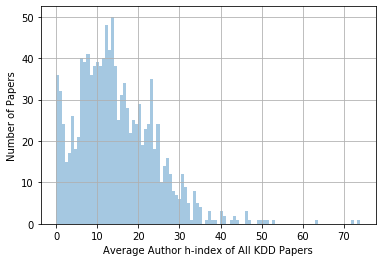

Reviewer features of size: (7075, 2348), h index of size (7075,)


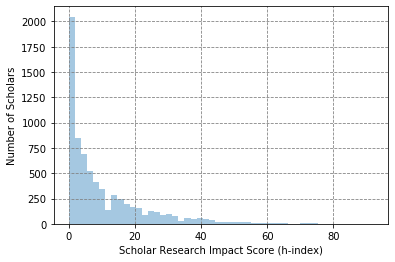

In [9]:
# Fixtures. We put these in upper cases, to prevent the functions accidentally use these values.

# Load papers
PAPER_POOL = Papers()
PAPER_FEATURE, PAPER_H_INDEX, PAPER_CITATION, PAPER_YEAR = PAPER_POOL.sample(
    1000
    #     1000
)  # Number of Submission
PAPER_POOL.plot()

# Load reviewers
REVIEWER_POOL = Reviewers()
REVIEWER_FEATURE, REVIEWER_H_INDEX = REVIEWER_POOL.sample(
    3000
    #     3000
)  # Number of Scholars
REVIEWER_POOL.plot()

MAX_H_INDEX = np.max(REVIEWER_H_INDEX)
MIN_H_INDEX = np.min(REVIEWER_H_INDEX)

MAX_LOG_AVG_CITATION = np.max(np.log((PAPER_CITATION + 1) / (2020 - PAPER_YEAR)))
MIN_LOG_AVG_CITATION = np.min(np.log((PAPER_CITATION + 1) / (2020 - PAPER_YEAR)))

In [10]:
# This cell just contain functions. Should be scope safe


def f_constant_submission_fee(simulation, fee):
    n_papers = simulation.p_feature.shape[0]
    return np.full((n_papers,), fee)


def f_h_index_based_submission_fee(simulation, fee):
    return [(1 - x) * fee for x in simulation.attractive]


def f_quality(simulation):
    return np.array(
        [
            (
                np.log((simulation.p_citation[_p] + 1) / (2020 - simulation.p_year[_p]))
                - MIN_LOG_AVG_CITATION
            )
            / (MAX_LOG_AVG_CITATION - MIN_LOG_AVG_CITATION)
            for _p in range(simulation.p_feature.shape[0])
        ]
    )


def f_attractive(simulation):
    return np.array(
        [
            (np.average(simulation.p_h_index[_p]) - MIN_H_INDEX)
            / (MAX_H_INDEX - MIN_H_INDEX)
            for _p in range(simulation.p_feature.shape[0])
        ]
    )


def calculate_score(quality):
    _random_sd = np.random.uniform(0.01, 0.1)
    _score = np.random.normal(loc=quality, scale=_random_sd, size=1)[0]
    _score = min(1, _score)
    _score = max(0, _score)
    return _score


def f_review_fee(simulation, policy):
    _scores = simulation.score.flatten()
    _scores = _scores[~np.isnan(_scores)]
    _percentiles = [np.percentile(_scores, _x) for _x, _ in policy]
    _balances = [_x for _, _x in policy]

    def calculate_balance(score):
        if np.isnan(score):
            return np.nan
        for _i in range(len(_percentiles)):
            if score <= _percentiles[_i]:
                return _balances[_i]

    return np.array(
        [
            [
                calculate_balance(simulation.score[_r][_p])
                for _p in range(simulation.p_feature.shape[0])
            ]
            for _r in range(simulation.r_feature.shape[0])
        ]
    )


def f_review_fee_h_index(simulation, policy):
    _scores = simulation.score.flatten()
    _scores = _scores[~np.isnan(_scores)]
    _percentiles = [np.percentile(_scores, _x) for _x, _ in policy]
    _balances = [_x for _, _x in policy]

    def calculate_balance(score):
        if np.isnan(score):
            return np.nan
        for _i in range(len(_percentiles)):
            if score <= _percentiles[_i]:
                return _balances[_i]

    return np.array(
        [
            [
                calculate_balance(simulation.score[_r][_p]) * simulation.attractive[_p]
                for _p in range(simulation.p_feature.shape[0])
            ]
            for _r in range(simulation.r_feature.shape[0])
        ]
    )


def f_score_flex_number_of_reviews(simulation: Simulation):
    _n_papers = simulation.p_feature.shape[0]
    _n_reviewers = simulation.r_feature.shape[0]
    _position_array = list(range(_n_papers * _n_reviewers))
    # np.random.seed(0)
    _do_review = np.random.rand(*simulation.likelihood.shape) < simulation.likelihood
    _result = np.array(
        [
            [
                calculate_score(simulation.quality[_p])
                if _do_review[_r][_p]
                else np.nan
                for _p in range(_n_papers)
            ]
            for _r in range(_n_reviewers)
        ]
    )
    print(f"Generated {sum(sum(~np.isnan(_result)))} reviews")
    return _result


# Dynamic way of running the experiments
def f_score_dynamic(simulation: Simulation):
    _n_papers = simulation.p_feature.shape[0]
    _n_reviewers = simulation.r_feature.shape[0]

    if simulation.score is None:
        simulation.score = np.empty((_n_reviewers, _n_papers))
        simulation.score[:] = np.NaN

    _position_array = list(range(_n_papers * _n_reviewers))

    _potential_reviews = (
        np.random.rand(*simulation.likelihood.shape) < simulation.likelihood
    )

    # If score has been assigned previously(reviewed before), we remove them from potential paper review pool
    _potential_reviews = np.logical_and(_potential_reviews, np.isnan(simulation.score))

    _indexes = [
        np.random.choice(np.where(row)[0]) if len(np.where(row)[0]) > 0 else None
        for row in _potential_reviews
    ]

    for _reviewer_idx, _paper_idx in zip(range(_potential_reviews.shape[0]), _indexes):
        if _paper_idx is not None:
            simulation.score[_reviewer_idx][_paper_idx] = calculate_score(
                simulation.quality[_paper_idx]
            )
    print(f"Now have {sum(sum(~np.isnan(simulation.score)))} reviews")
    return simulation.score


def f_similarity(simulation, gamma=None):
    # cdist is calling into optimised C code, no waste on type checking, but no multiprocessing (no need for GPU)
    # broadcast gamma in numpy (optimised C as well)
    return np.multiply(
        (
            1
            - spatial.distance.cdist(
                simulation.p_feature, simulation.r_feature, "cosine"
            )
        ),
        np.zeros(simulation.r_feature.shape[0]) if gamma is None else gamma,
    ).T


def f_token_incentive(
    s: "Simulation", critical_review_fee, contructive_review_fee, alpha=None
):
    if alpha is None:
        alpha = np.zeros(s.r_feature.shape[0])

    # for each paper, calculates the total number of reviews, if a reviewer decides to review. (+1 to the existing number of reviews)
    if s.score is None:
        # all elements equal to 1 initially
        _review_counts = np.ones(s.p_feature.shape[0])
    else:
        # broadcast 1 to the number of reviews for each paper
        _review_counts = np.sum(~np.isnan(s.score), axis=0) + 1

    #
    _paper_incentive = np.array(
        [
            (
                -0.5 * np.tanh(8 * (s.quality[_p] - 0.5))
                + 0.5
                * (critical_review_fee - contructive_review_fee)
                / (critical_review_fee + contructive_review_fee)
            )
            for _p in range(s.p_feature.shape[0])
        ]
    )
    # return np.dot(
    #     alpha.reshape((-1, 1)), (_paper_incentive / _review_counts).reshape((1, -1))

    return np.dot(alpha.reshape((-1, 1)), _paper_incentive.reshape((1, -1)))


def f_reputation_incentive(_simulation, beta=None):
    if beta is None:
        beta = np.zeros(_simulation.r_feature.shape[0])
    incentive = np.array(
        [
            ((_simulation.quality[_p]) ** 2)
            for _p in range(_simulation.p_feature.shape[0])
        ]
    )
    return np.dot(beta.reshape((-1, 1)), incentive.reshape((1, -1)))


class TestNotebook(unittest.TestCase):
    def setUp(self):
        self.s = Simulation(
            p_feature=np.array([[0.1, 0.2, 0], [0, 0.1, 0.2]]),
            p_h_index=np.array([10, 5]),
            p_citation=np.array([100, 5]),
            p_year=np.array([2018, 2017]),
            r_feature=np.array([[0.1, 0.2, 0], [0, 0.1, 0.2], [0.1, 0, 0.2]]),
            r_h_index=np.array([10, 5, 2]),
        )

    def test_f_similarity(self):
        # testing when gamma = 1 (avoiding the impact of gamma)
        _similarity = f_similarity(self.s, 1)
        # reviewer 1 perfectly match paper 1, reviewer 2 perfectly match paper 2
        np.testing.assert_array_almost_equal(
            _similarity, [[1.00, 0.40], [0.40, 1.00], [0.20, 0.80]]
        )

    def test_f_quality(self):
        # quality depends on citation and year.
        np.testing.assert_array_almost_equal(f_quality(self.s), [0.92, 0.4], 2)

    def test_f_token_incentive_(self):
        # token incentive depends on quality only
        self.s.calculate_quality(f_quality)
        np.testing.assert_array_almost_equal(
            f_token_incentive(self.s, 5, 5, np.array([0, 0.5, 1])),
            [[0, 0], [-0.25, 0.17], [-0.50, 0.33]],
            2,
        )

    def test_f_token_incentive_critical_pays_more(self):
        # token incentive depends on quality only
        self.s.calculate_quality(f_quality)
        np.testing.assert_array_almost_equal(
            f_token_incentive(self.s, 10, 5, np.array([0, 0.5, 1])),
            [[0, 0], [-0.17, 0.25], [-0.33, 0.50]],
            2,
        )

    def test_f_token_incentive_constructive_pays_more(self):
        # token incentive depends on quality only
        self.s.calculate_quality(f_quality)
        np.testing.assert_array_almost_equal(
            f_token_incentive(self.s, 5, 10, np.array([0, 0.5, 1])),
            [[0, 0], [-0.33, 0.08], [-0.67, 0.16]],
            2,
        )

    def test_f_reputation_incentive(self):
        # square of quality, the higher the quality, the more interested the reviewers.
        self.s.calculate_quality(f_quality)
        np.testing.assert_array_almost_equal(
            f_reputation_incentive(self.s, np.array([0, 0.5, 1])),
            [[0, 0], [0.42, 0.08], [0.85, 0.16]],
            2,
        )


unittest.main(argv=[""], verbosity=2, exit=False)

test_f_quality (__main__.TestNotebook) ... FAIL
test_f_reputation_incentive (__main__.TestNotebook) ... FAIL
test_f_similarity (__main__.TestNotebook) ... ok
test_f_token_incentive_ (__main__.TestNotebook) ... FAIL
test_f_token_incentive_constructive_pays_more (__main__.TestNotebook) ... FAIL
test_f_token_incentive_critical_pays_more (__main__.TestNotebook) ... FAIL

FAIL: test_f_quality (__main__.TestNotebook)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-10-917f92f3fe3c>", line 224, in test_f_quality
    np.testing.assert_array_almost_equal(f_quality(self.s), [0.92, 0.4], 2)
  File "/home/ec2-user/miniconda3/lib/python3.7/site-packages/numpy/testing/_private/utils.py", line 1029, in assert_array_almost_equal
    precision=decimal)
  File "/home/ec2-user/miniconda3/lib/python3.7/site-packages/numpy/testing/_private/utils.py", line 841, in assert_array_compare
    raise AssertionError(msg)
AssertionError

In [11]:
_s = Simulation(
    copy.deepcopy(PAPER_FEATURE),
    copy.deepcopy(PAPER_H_INDEX),
    copy.deepcopy(PAPER_CITATION),
    copy.deepcopy(PAPER_YEAR),
    copy.deepcopy(REVIEWER_FEATURE),
    copy.deepcopy(REVIEWER_H_INDEX),
)

print(_s.p_feature.shape)
print(_s.p_h_index.shape)
print(_s.p_citation.shape)
print(_s.p_year.shape)
print(_s.r_feature.shape)
print(_s.r_h_index.shape)

(1000, 2348)
(1000,)
(1000,)
(1000,)
(3000, 2348)
(3000,)


In [12]:
# Again it should be safe here


def get_statistics(s: "Simulation"):
    number_of_reviews = (~np.isnan(s.score)).sum()

    avg_attractive_0_review_paper = np.average(
        s.attractive[(~np.isnan(s.score)).sum(axis=0) == 0]
    )
    avg_attractive_all_paper = np.average(s.attractive)

    avg_quality_0_review_paper = np.average(
        s.quality[(~np.isnan(s.score)).sum(axis=0) == 0]
    )
    avg_quality_all_paper = np.average(s.quality)

    zero_review_paper_rate = (
        (~np.isnan(s.score)).sum(axis=0) == 0
    ).sum() / s.p_feature.shape[0]

    zero_review_scholar_rate = (
        (~np.isnan(s.score)).sum(axis=1) == 0
    ).sum() / s.r_feature.shape[0]

    statistics = [
        number_of_reviews,
        round(zero_review_paper_rate, 6),
        round(zero_review_scholar_rate, 6),
        round(avg_attractive_0_review_paper, 6),
        round(avg_attractive_all_paper, 6),
        round(avg_quality_0_review_paper, 6),
        round(avg_quality_all_paper, 6),
    ]

    return statistics

In [17]:
%%time

# lets put the entire simulation in a function scope to avoid any scoping problems

# Simulation Parameters:
# number_of_reviews - Parameters to tune
# p_feature, p_h_index, r_feature, r_h_index - Paper and scholar features
# fees - submission fee
# f_quality - function to compute paper quality
# f_similarity - function to compute reviewer and paper simularity
# f_score - function to compute review score
# policy [[negative upperbound, critical review fee], [positive upperbound, constructive review fee]]


def run(
    file_name,
    submission_fee,
    a_step_size,
    b_step_size,
    a_std,
    b_std,
    g_mean,
    g_std,
    a_mean,
    b_mean,
    theta,
    critical_review_fee,
    contructive_review_fee,
):
    
    # we do not want the fixtures to be modified, lets use a copy
    _s = Simulation(
        copy.deepcopy(PAPER_FEATURE),
        copy.deepcopy(PAPER_H_INDEX),
        copy.deepcopy(PAPER_CITATION),
        copy.deepcopy(PAPER_YEAR),
        copy.deepcopy(REVIEWER_FEATURE),
        copy.deepcopy(REVIEWER_H_INDEX),
    )
    
    # Paper Attractiveness - based on authors' h-index
    _s.calculate_attractive(f_attractive)
    _s.calculate_quality(f_quality)

    # Constant submission fee
    _s.calculate_submission_fees(lambda _x: f_constant_submission_fee(_x, submission_fee))
    
    
    # Likelihood
    
    #alpha = np.random.normal(parameters[0], parameters[1], _s.r_feature.shape[0])
    _results = []
    



    _critical_percentile = (_s.quality < theta).sum()/_s.p_feature.shape[0] *100


    for k in range(1):
        _alpha = truncnorm((0 - a_mean)/a_std,(1 - a_mean)/a_std, loc = a_mean, scale = a_std).rvs(_s.r_feature.shape[0]) 
        _beta = truncnorm((0 - b_mean)/b_std,(1 - b_mean)/b_std, loc = b_mean, scale = b_std).rvs(_s.r_feature.shape[0]) 
        _gamma = truncnorm((0 - g_mean)/g_std,(1 - g_mean)/g_std, loc = g_mean, scale = g_std).rvs(_s.r_feature.shape[0])  


        likelihood_function = lambda x: (np.maximum(0,np.minimum(1,f_similarity(x, _gamma) + f_token_incentive(x, critical_review_fee, contructive_review_fee, _alpha)+ f_reputation_incentive(x, _beta),),))
        _s.calculate_review_likelihood(likelihood_function)
        _s.calculate_review_scores(f_score_flex_number_of_reviews)


        # Review fee
        _s.calculate_review_fees(lambda x: f_review_fee(x, [[_critical_percentile, -critical_review_fee], [100, contructive_review_fee]]))

        # Final balance

        _s.calculate_final_balance()


        _parameters = [round(a_mean, 4), round(b_mean, 4), round(g_mean, 4), round(a_std, 4), round(b_std, 4), round(g_std, 4), critical_review_fee, contructive_review_fee, submission_fee]
        _result = _parameters + get_statistics(_s)

        for _year in [2014, 2015, 2016, 2017, 2018]:
            for _rate in [0.1, 0.2, 0.3, 0.4]:
                _indexes = np.where(_s.p_year == _year)[0]
                _top = int(len(_indexes) * _rate)
                _citation_counts = _s.p_citation[_indexes]
                _balance = _s.p_balances[_indexes]

                _citation_boolean = [
                    1
                    if i
                    in sorted(range(len(_citation_counts)), key=lambda i: _citation_counts[i])[-_top:]
                    else 0
                    for i in range(len(_citation_counts))
                ]

                _fpr, _tpr, _thresholds = metrics.roc_curve(
                    _citation_boolean, _balance, drop_intermediate=False
                )
                _roc_auc = metrics.auc(_fpr, _tpr)

                _result = _result + [round(_roc_auc, 4)]

        _results.append(_result)
        
        
    with open(file_name, "w") as fd:
        fd.write(
            f'{",".join(["a_mean", "b_mean", "g_mean", "a_std", "b_std", "g_std", "critical_review_fee", "contructive_review_fee", "submission_fee", "number_of_reviews", "zero_review_paper_rate", "zero_review_scholar_rate", "avg_attractive_0_review_paper", "avg_attractive_all_paper", "avg_quality_0_review_paper", "avg_quality_all_paper", "2014-0.1", "2014-0.2", "2014-0.3", "2014-0.4", "2015-0.1", "2015-0.2", "2015-0.3", "2015-0.4", "2016-0.1", "2016-0.2", "2016-0.3", "2016-0.4", "2017-0.1", "2017-0.2", "2017-0.3", "2017-0.4", "2018-0.1", "2018-0.2", "2018-0.3", "2018-0.4"])}'
            + "\n"
        )
        for _line in _results:
            fd.write(f'{",".join(str(_x) for _x in _line)}' + "\n")
    
    return _s


SIMULATION_RESULT = run(
    file_name = "./results_ROC_beta_testing.csv",
    submission_fee = 20,
    a_step_size = 0.0004,
    b_step_size = 0.0012,
    a_std = 0.0004 / 4,
    b_std = 0.0012 / 4,
    g_mean = 0.003,
    g_std = 0.002 / 4,
    a_mean = 0.003,
    b_mean = 0.01,
    # theta = 0.45 leads to acceptance rate ~20%
    theta = 0.45,
    critical_review_fee = 5,
    contructive_review_fee = 5,
)

Generated 7153 reviews


/home/ec2-user/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/home/ec2-user/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in multiply


CPU times: user 37.8 s, sys: 419 ms, total: 38.2 s
Wall time: 35.5 s


223


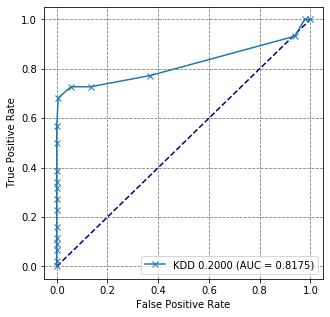

In [41]:
def plot_auc(simulation: "Simulation"):
    plt.figure(figsize=(5, 5))
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

    # _year = 2016
    _rate = 0.2

    # for _year in [2014, 2015, 2016, 2017, 2018]:
    for _year in [2018]:
        # for _rate in [0.1, 0.2, 0.3, 0.4]:

        _indexes = np.where(simulation.p_year == _year)[0]
        print(len(_indexes))
        _top = int(len(_indexes) * _rate)
        _citation_counts = simulation.p_citation[_indexes]
        _balance = simulation.p_balances[_indexes]

        _citation_boolean = [
            1
            if _i
            in sorted(range(len(_citation_counts)), key=lambda i: _citation_counts[i])[
                -_top:
            ]
            else 0
            for _i in range(len(_citation_counts))
        ]

        _fpr, _tpr, _thresholds = metrics.roc_curve(
            _citation_boolean, _balance, drop_intermediate=False
        )
        _roc_auc = metrics.auc(_fpr, _tpr)

        plt.plot(
            _fpr, _tpr, marker="x", label="KDD %0.4f (AUC = %0.4f)" % (_rate, _roc_auc)
        )

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    plt.rc("grid", linestyle="--", color="gray")
    plt.grid(which="major")
    plt.legend(loc="lower right")


plot_auc(SIMULATION_RESULT)

223
44
[3.00 1.00 3.00 3.00 2.00 4.00 15.00 2.00 1.00 3.00 11.00 1.00 24.00 1.00
 5.00 2.00 0.00 3.00 3.00 13.00 2.00 6.00 1.00 7.00 5.00 8.00 2.00 8.00
 2.00 2.00 9.00 4.00 5.00 18.00 3.00 27.00 0.00 23.00 11.00 10.00 17.00
 8.00 4.00 3.00]
[0.00 0.00 0.00 0.00 0.00 0.00 25.00 0.00 0.00 -0.00 0.00 10.00 40.00 0.00
 0.00 0.00 0.00 0.00 0.00 15.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 -0.00
 0.00 0.00 0.00 0.00 0.00 30.00 0.00 60.00 10.00 25.00 0.00 0.00 15.00
 0.00 0.00 5.00]


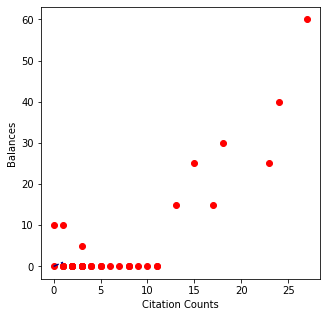

In [42]:
def plot_corr(simulation: "Simulation"):
    plt.figure(figsize=(5, 5))
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

    # _year = 2016
    _rate = 0.2

    # for _year in [2014, 2015, 2016, 2017, 2018]:
    for _year in [2018]:
        # for _rate in [0.1, 0.2, 0.3, 0.4]:

        _indexes = np.where(simulation.p_year == _year)[0]
        print(len(_indexes))
        _top = int(len(_indexes) * _rate)
        print(_top)
        _citation_counts = simulation.p_citation[_indexes]
        print(_citation_counts[-_top:])
        _balance = simulation.p_balances[_indexes]
        print(_balance[-_top:])

        plt.scatter(_citation_counts[-_top:], _balance[-_top:], color="red")

    plt.xlabel("Citation Counts")
    plt.ylabel("Balances")


plot_corr(SIMULATION_RESULT)

In [39]:
SIMULATION_RESULT2 = run(
    file_name="./results_ROC_beta_testing.csv",
    submission_fee=20,
    a_step_size=0.0004,
    b_step_size=0.0012,
    a_std=0.0004 / 4,
    b_std=0.0012 / 4,
    g_mean=0.003,
    g_std=0.002 / 4,
    a_mean=0.003,
    b_mean=0.003,
    # theta = 0.45 leads to acceptance rate ~20%
    theta=0.45,
    critical_review_fee=5,
    contructive_review_fee=5,
)

Generated 4439 reviews


/home/ec2-user/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/home/ec2-user/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in multiply


163


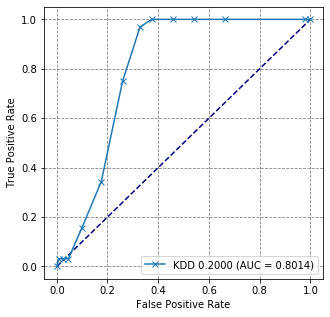

In [40]:
plot_auc(SIMULATION_RESULT2)